# Plant Seedlings Classification Project
by Michele Casalgrandi

## Context
The Aarhus University Signal Processing group released a dataset of images of unique plants belonging to 12 species at several growth stages.

## Goals
* Develop models to classify images of the different species using Convolutional Neural Networks (CNN).

## Data
* Provided is a numpy array of images and a .csv files with the labels

Import needed libraries

In [1]:
import numpy as np
import math
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
import cv2
from scipy import stats

from scipy.signal import convolve2d               # Convolve two 2-dimensional arrays.

%matplotlib inline

import seaborn as sns

# rnd.seed = 1

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from google.colab.patches import cv2_imshow # cv2.imshow() crashes colab

from tensorflow.keras.initializers import he_normal, he_uniform, GlorotNormal, GlorotUniform, LecunNormal

### Exploratory Data Analysis - EDA

Load images and labels

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = "/content/drive/MyDrive/data/"
images = np.load(path + '/' + 'images.npy')
print(type(images))
print(images.shape)

labels_df = pd.read_csv(path + '/' + 'Labels.csv')
labels = labels_df.to_numpy()
print(labels.shape) 

<class 'numpy.ndarray'>
(4750, 128, 128, 3)
(4750, 1)


The dataset contains 4750 images of size 128x128 and 3 channels

In [4]:
print('Min pixel intensity:', images.min())
print('Max pixel intensity:', images.max())
print('Pixel intensity mean:', round(images.mean(),1))
print('Pixel intensity std deviation:', round(images.std(), 1))

Min pixel intensity: 0
Max pixel intensity: 255
Pixel intensity mean: 70.0
Pixel intensity std deviation: 32.0


#### Review a sample of the images

In [5]:
# define function to plot a grid of pictures
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_image_samples(size, images, labels, indexes=None):
    if not indexes:
        indexes = rnd.sample(range(0,images.shape[0]), size[0] * size[1])    
    fig = plt.figure(figsize=(size[1] * 3, size[0] * 3))
    grid = ImageGrid(fig, 111, nrows_ncols=size,axes_pad=0.4)
    for ax, im, label in zip(grid, images[indexes], labels[indexes]):
      ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
      ax.set_title(label)
    plt.show()

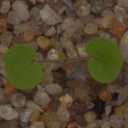

In [6]:
cv2_imshow(images[0])

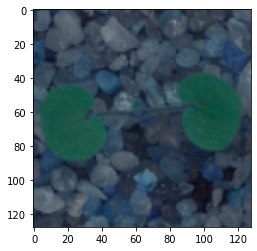

In [7]:
plt.imshow(images[0])

Images are stored as BGR - we will convert to RGB so we can use matplotlib imshow()

In [8]:
# initialize an array with same shape as original
images_RGB = np.zeros(images.shape)
images_RGB.shape

(4750, 128, 128, 3)

In [9]:
# convert to RGB
for idx, im in enumerate(images):
  images_RGB[idx] = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
images_RGB = images_RGB.astype('int')

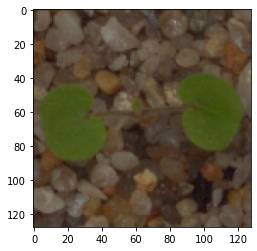

In [10]:
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))

In [11]:
# print stats for original and RGB array
print('Original array:', 'Mean:',round(images.mean(),2),'Min:',images.min(),'Max:',images.max())
print('RGB array:', 'Mean:',round(images_RGB.mean(),2),'Min:',images_RGB.min(),'Max:',images_RGB.max())

Original array: Mean: 70.04 Min: 0 Max: 255
RGB array: Mean: 70.04 Min: 0 Max: 255


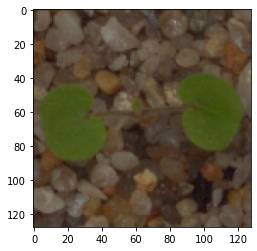

In [12]:
plt.imshow(images_RGB[0])

Select random sample from the images

In [13]:
# select a sample of the pictures
grid_size = (2,6)
sample_images_idx = rnd.sample(range(0,images_RGB.shape[0]), grid_size[0] * grid_size[1])
print(sample_images_idx)

[4321, 3478, 2469, 212, 3769, 806, 3041, 4014, 41, 2011, 3140, 3030]


In [14]:
# define function to plot a grid of pictures
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_image_samples(size, images, labels, indexes=None):
    if not indexes:
        indexes = rnd.sample(range(0,images.shape[0]), size[0] * size[1])    
    fig = plt.figure(figsize=(size[1] * 3, size[0] * 3))
    grid = ImageGrid(fig, 111, nrows_ncols=size,axes_pad=0.4)
    for ax, im, label in zip(grid, images[indexes], labels[indexes]):
      ax.imshow(im)
      ax.set_title(label)
    plt.show()

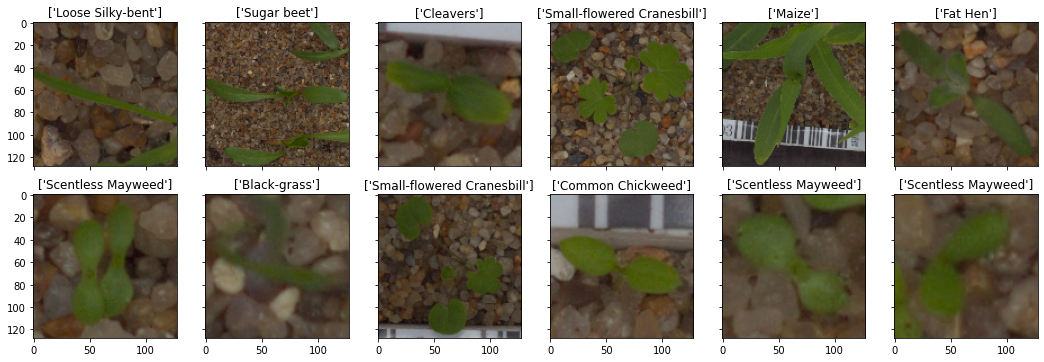

In [15]:
# plot the sample
plot_image_samples(grid_size, images_RGB, labels, sample_images_idx)

* Images are low resolution of 128 by 128.  
* Some images are blurred
* The images have low contrast
* Background is gravel
* A ruler is present in some pictures
    * Orientation of the ruler varies between pictures

##### Pixel intensities histograms

In [16]:
# define function to plot the images histograms
def plot_histograms(size, images, labels, indexes):
    rows = size[0]
    cols = size[1]
    fig = plt.figure(figsize=(cols * 3, rows * 3))
    idx=0
    bins=20
    xrange=(images.min(),images.max())
    for row in range(rows):
        for col in range(cols):
            plt.subplot(rows, cols, idx+1)
            plt.hist(images[indexes[idx]].flatten(), bins=60, range=xrange, density=True, stacked=False)
            fig.x_title=labels[indexes[idx]]
            idx += 1
    plt.show()

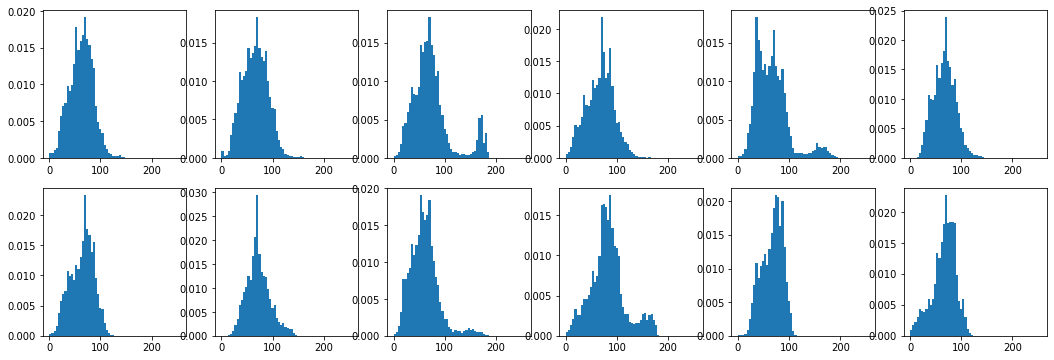

In [17]:
# plot the histograms
plot_histograms(grid_size, images_RGB, labels, sample_images_idx)

The pixel intensities are skewed to the right, indicating the images tend to be dark.  
The narrow shape of the distribution indicates they are low contrast.

Images with the ruler have a second peak due to the bright white areas of the ruler.

#### Labels

In [18]:
labels_df

Label
0     Small-flowered Cranesbill
1     Small-flowered Cranesbill
2     Small-flowered Cranesbill
3     Small-flowered Cranesbill
4     Small-flowered Cranesbill
...                         ...
4745           Loose Silky-bent
4746           Loose Silky-bent
4747           Loose Silky-bent
4748           Loose Silky-bent
4749           Loose Silky-bent

[4750 rows x 1 columns]

In [19]:
# print out unique values of the labels
labels_counts = labels_df['Label'].value_counts()
print(labels_counts)
labels_ordered = labels_counts.index.to_list()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Label, dtype: int64


In [20]:
print('There are', len(labels_ordered), 'levels:',labels_ordered)

There are 12 levels: ['Loose Silky-bent', 'Common Chickweed', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Fat Hen', 'Charlock', 'Sugar beet', 'Cleavers', 'Black-grass', 'Shepherds Purse', 'Maize', 'Common wheat']


The classes are imbalanced.   
E.g. There are roughly three time as many 'Loose Silky-bent' as 'Common wheat'

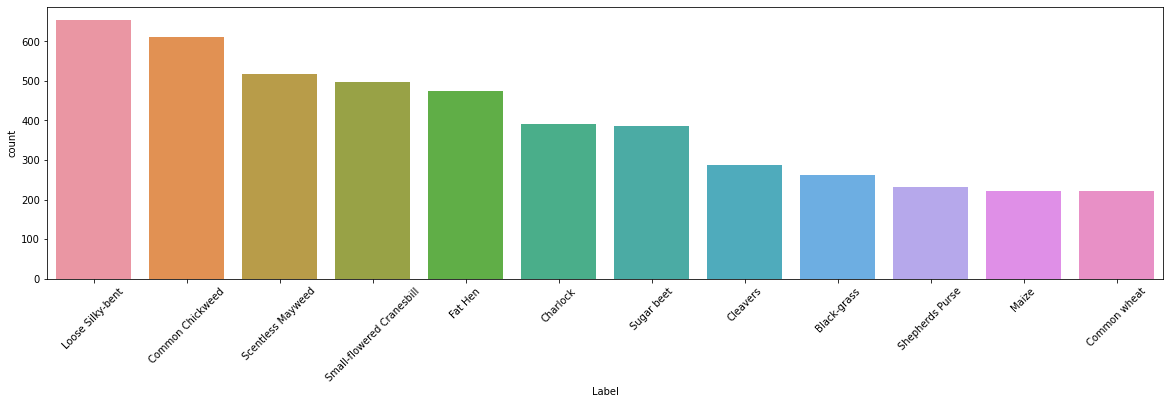

In [21]:
# plot graph sorted by count
fig = plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.countplot(x=labels_df['Label'], order=labels_ordered)

In [22]:
# get the list of indexes for each category so we can select from them
images_by_category = []
for categ in labels_ordered:
    categ_indexes = labels_df[labels_df['Label'] == categ].index.to_list()
    images_by_category.append(categ_indexes)

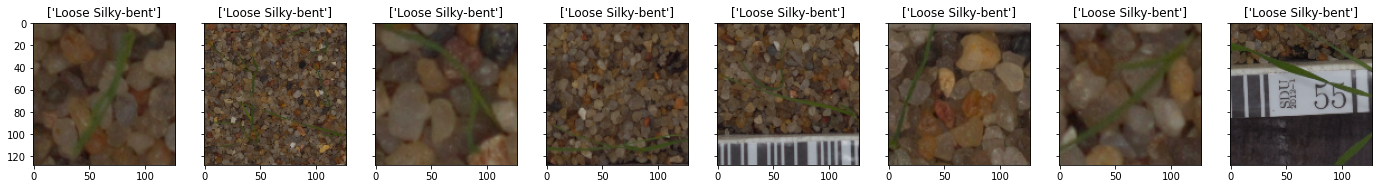

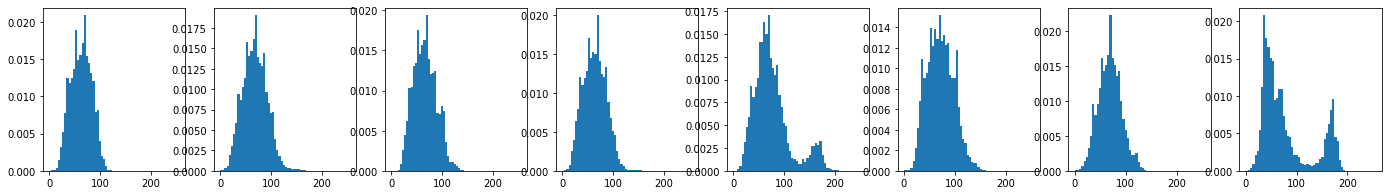

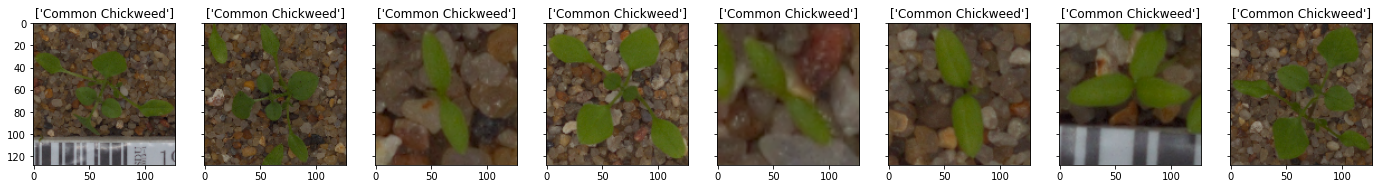

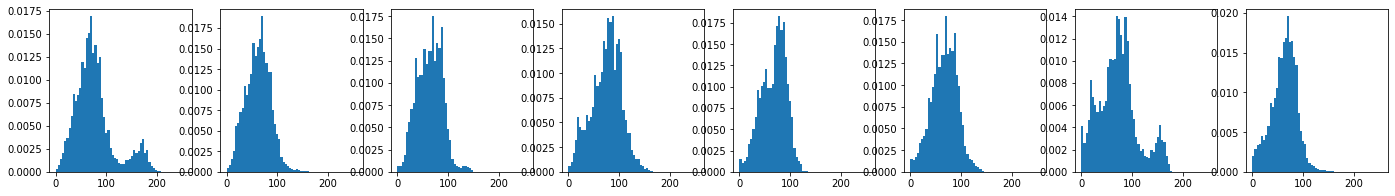

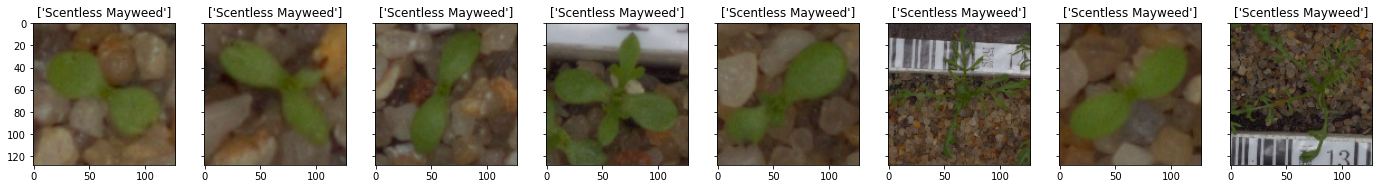

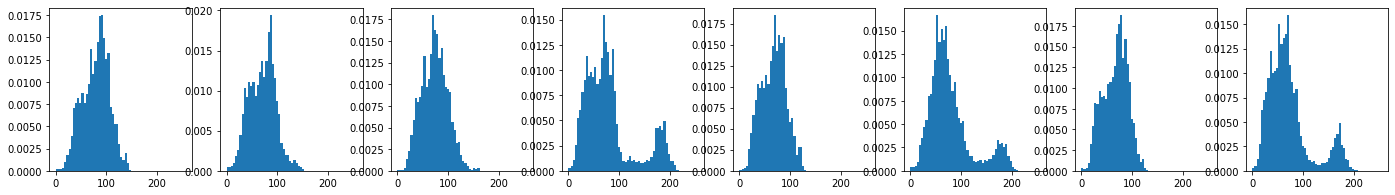

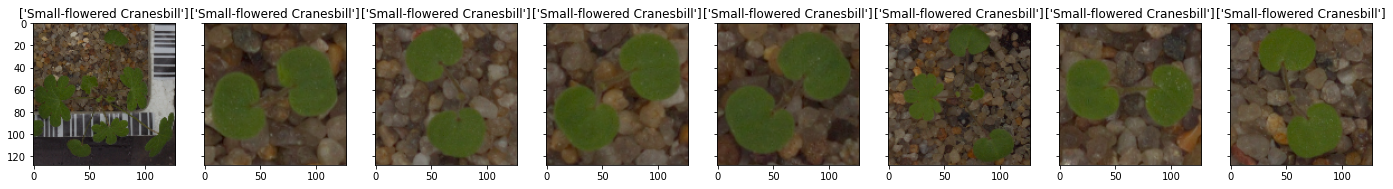

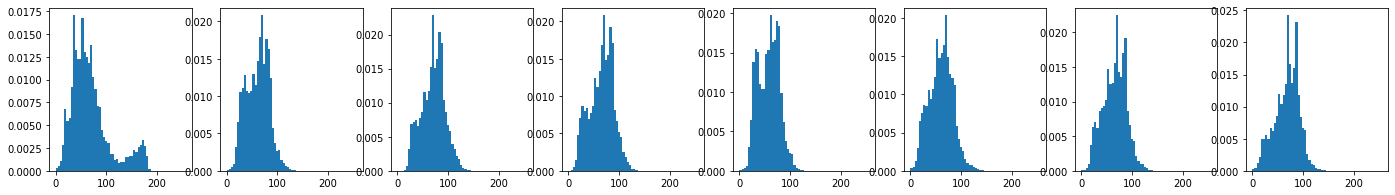

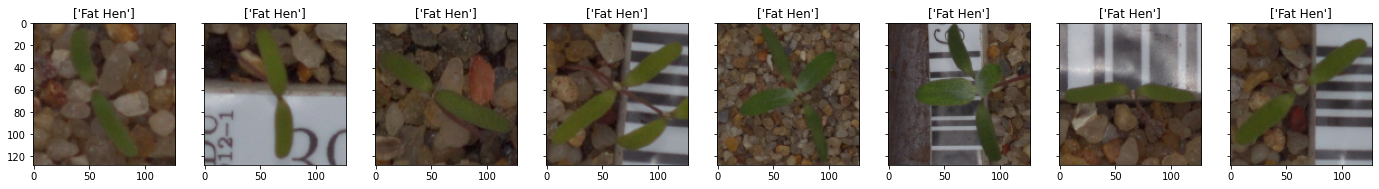

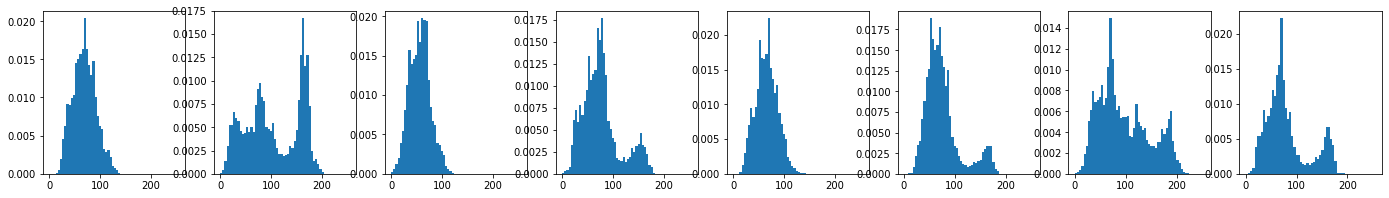

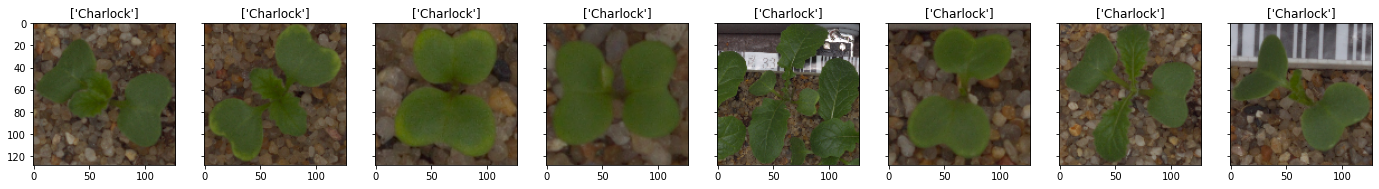

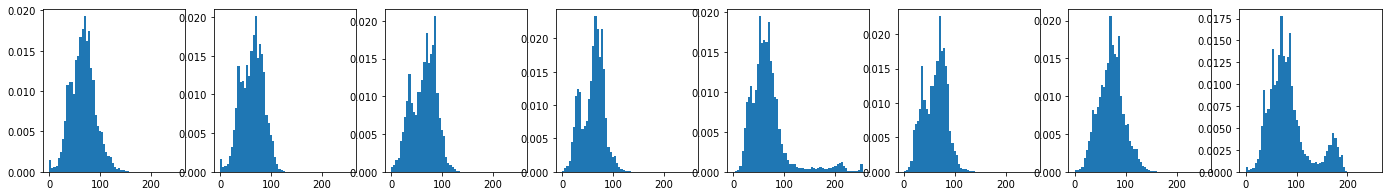

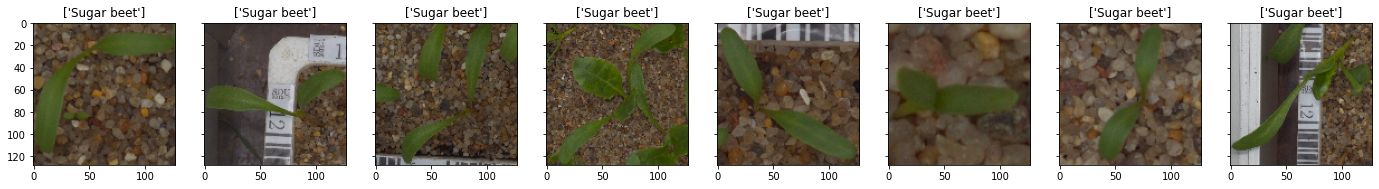

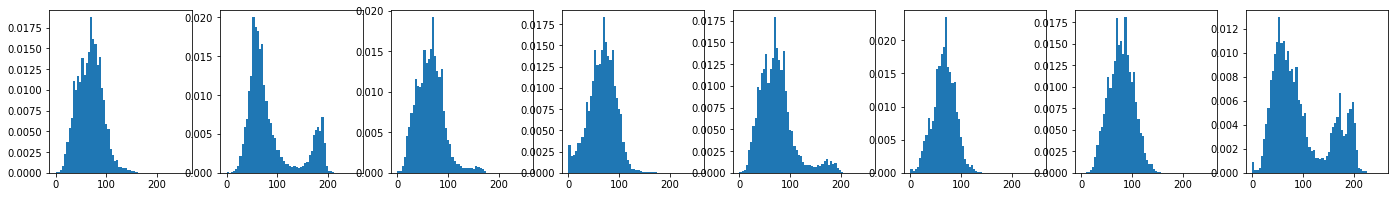

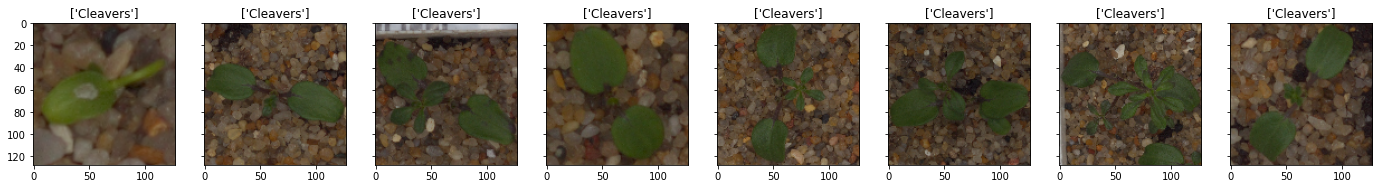

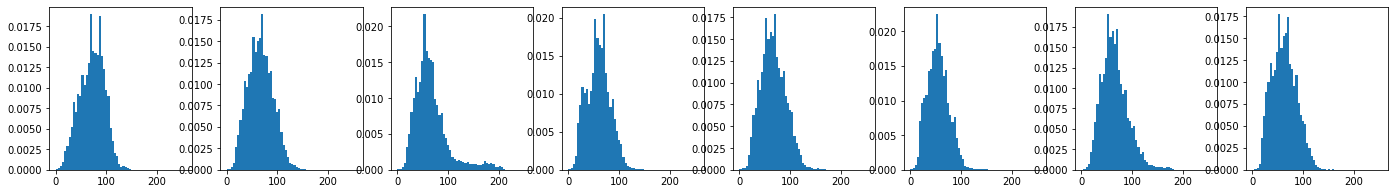

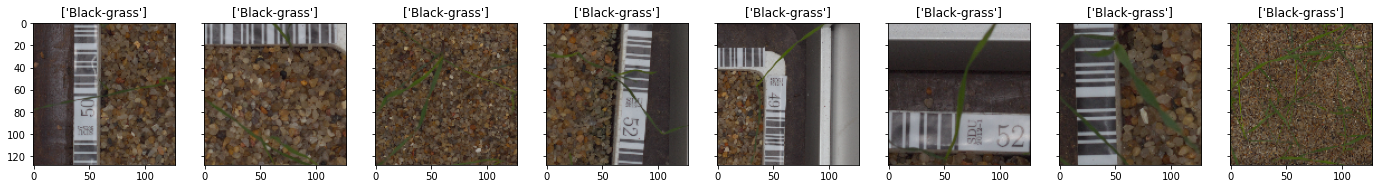

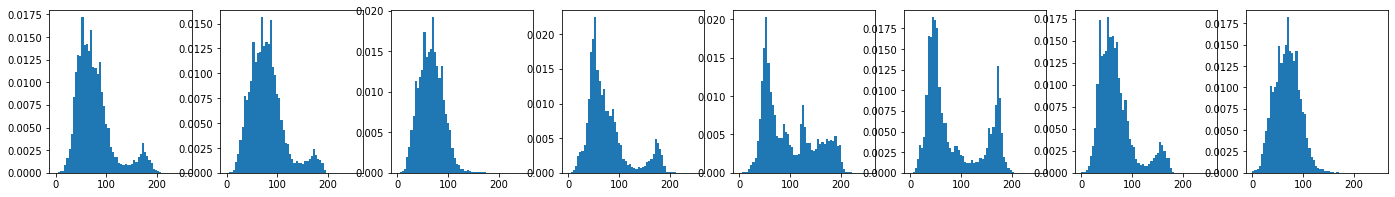

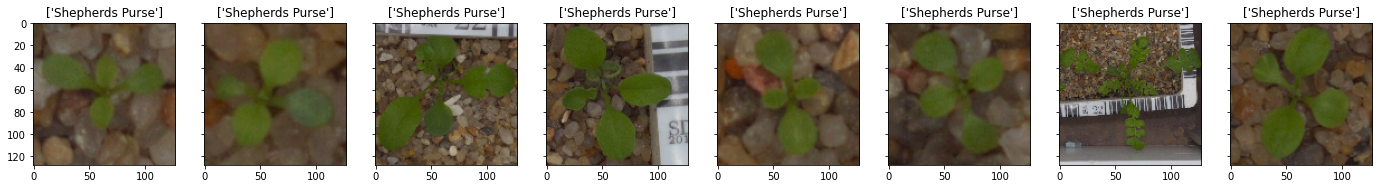

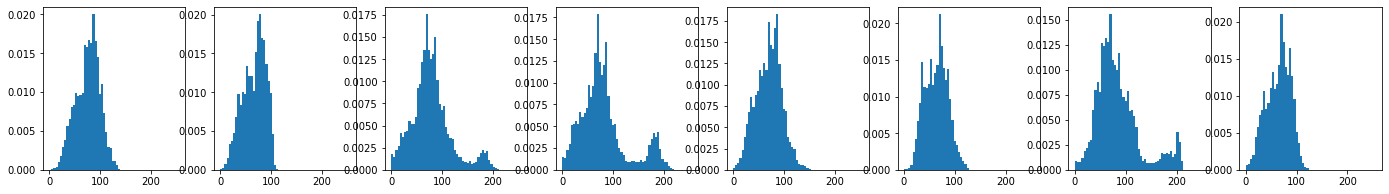

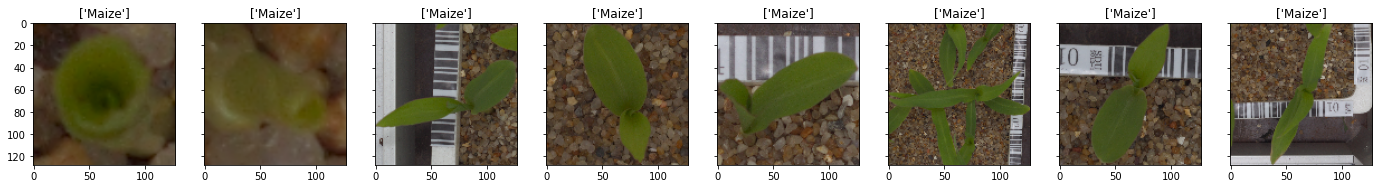

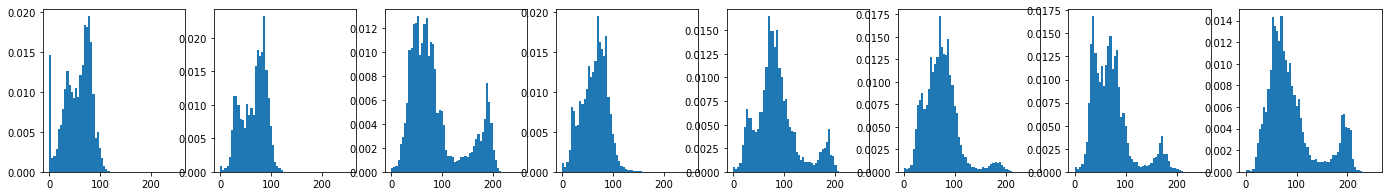

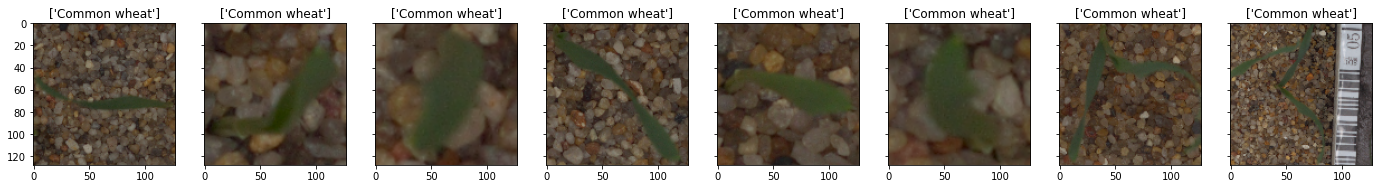

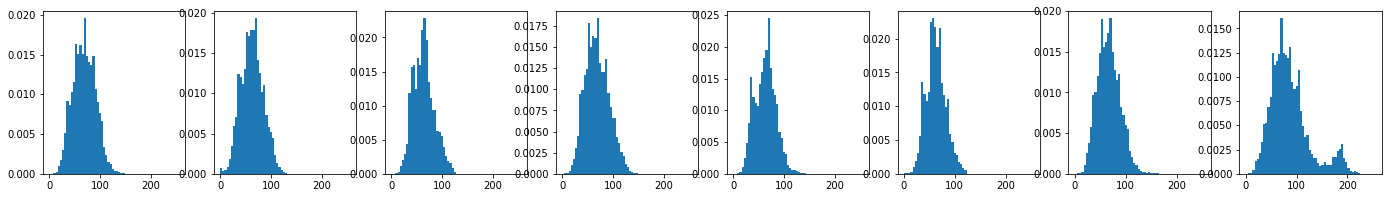

In [23]:
# show images for each category
grid_size_categ = (1,8)
for categ in labels_ordered:
    # total images = rows * columsn
    img_count = grid_size_categ[0]*grid_size_categ[1]
    # get position in array of category 
    categ_idx = labels_ordered.index(categ)
    # get random samples from that category
    categ_indexes = rnd.sample(images_by_category[categ_idx], img_count)
    # plot images 
    plot_image_samples(grid_size_categ, images_RGB, labels, categ_indexes)
    # plot histograms
    plot_histograms(grid_size_categ, images_RGB, labels, categ_indexes)

### Data Preprocessing
#### Normalization

In [24]:
print('Mean', images_RGB.mean())
print('Min', images_RGB.min())
print('Max', images_RGB.max())

Mean 70.04363745545504
Min 0
Max 255


In [25]:
# normalize to range 0, 1
images_post_prep = images_RGB / 255

In [26]:
print('Mean', images_post_prep.mean())
print('Min', images_post_prep.min())
print('Max', images_post_prep.max())

Mean 0.2746809311978636
Min 0.0
Max 1.0


In [27]:
images_post_prep.shape

(4750, 128, 128, 3)

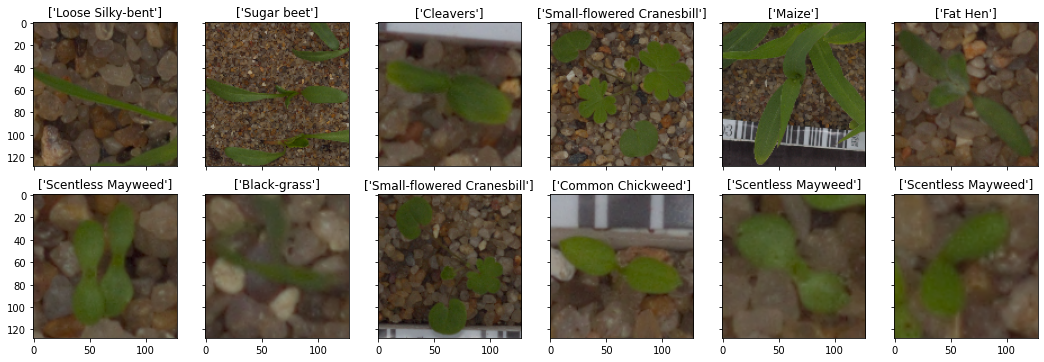

In [28]:
# plot the sample after normalization
plot_image_samples(grid_size, images_post_prep, labels, sample_images_idx)

#### Gaussian Blur

Resize one image and test gaussian blur. 

In [29]:
IMAGE_SIZE = (64, 64)  # target size of image

# resize the first image, index = 0
image = cv2.resize(images_post_prep[0], dsize=IMAGE_SIZE)

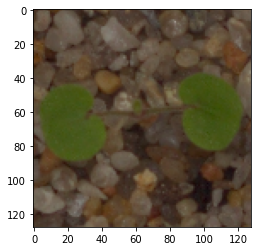

In [30]:
# render original
plt.imshow(images_post_prep[0])

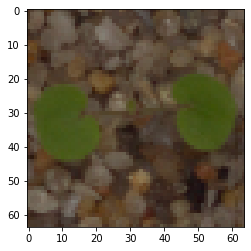

In [31]:
# render resized image
plt.imshow(image)

In [32]:
# blur with 5 by 5 kernel
kernel_size = (5,5)
image_blur = cv2.GaussianBlur(image, kernel_size, 1, 1)

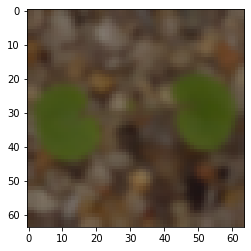

In [33]:
# render blurred image
plt.imshow(image_blur)

Resize and blur the entire array of images

In [34]:
# initialize an array with same shape as source
images_resize_blur = np.zeros((images_post_prep.shape[0],) + IMAGE_SIZE + (3,))
images_resize_blur.shape

(4750, 64, 64, 3)

In [35]:
# check type
images_resize_blur.dtype

dtype('float64')

In [36]:
# resize the images and blur
for idx, img in enumerate(images_post_prep):
    blurred = cv2.GaussianBlur(
            cv2.resize(img, IMAGE_SIZE), 
            kernel_size, 1, 1)
    images_resize_blur[idx] = blurred

In [37]:
# check new shape
images_resize_blur.shape

(4750, 64, 64, 3)

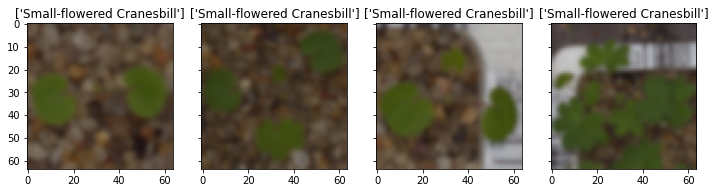

In [38]:
# view a small sample of the images
plot_image_samples((1,4), images_resize_blur, labels, range(4))

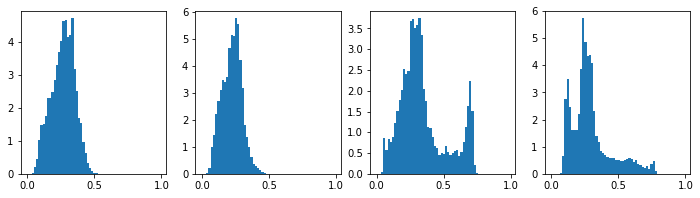

In [39]:
plot_histograms((1,4), images_resize_blur, labels, range(4))

View the images for each category after resizing and blurring

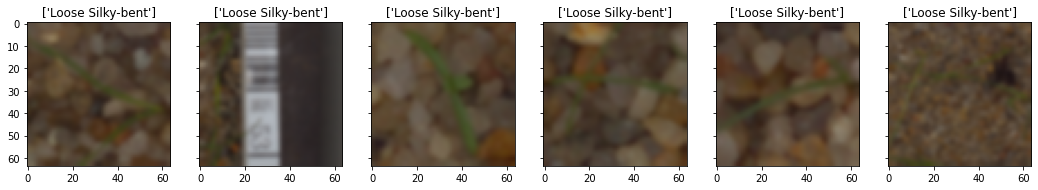

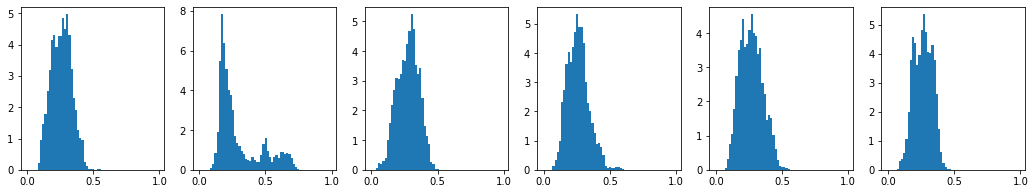

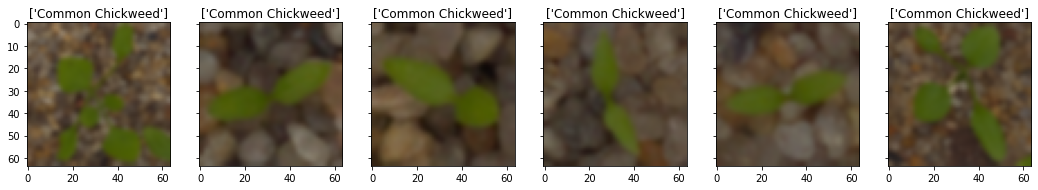

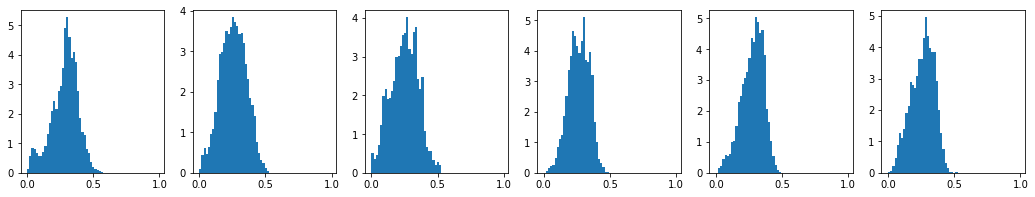

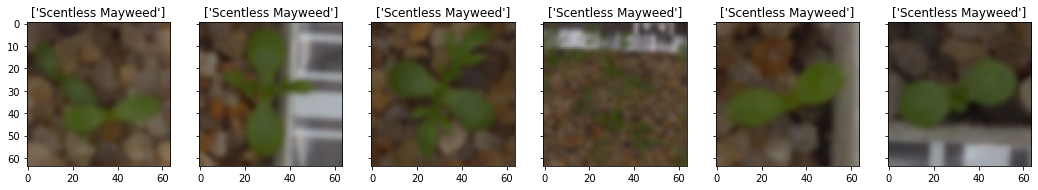

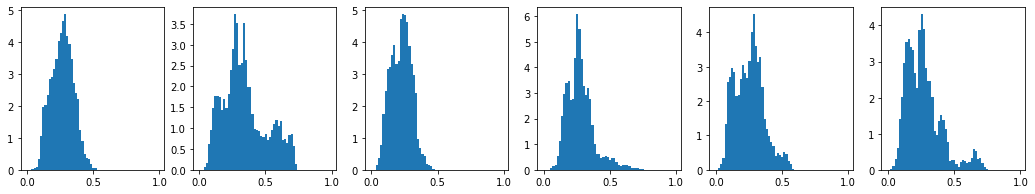

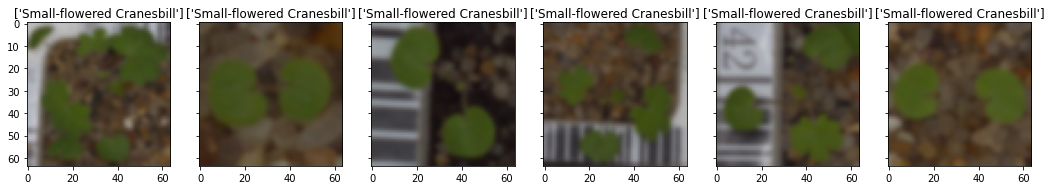

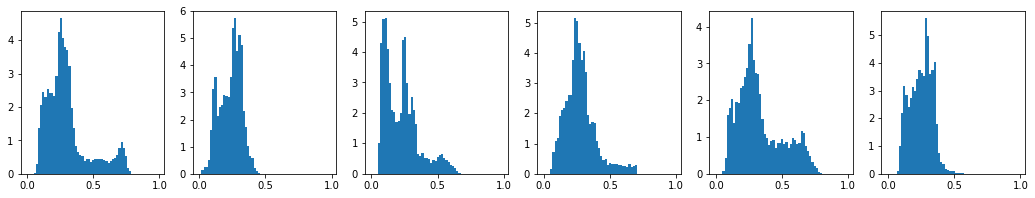

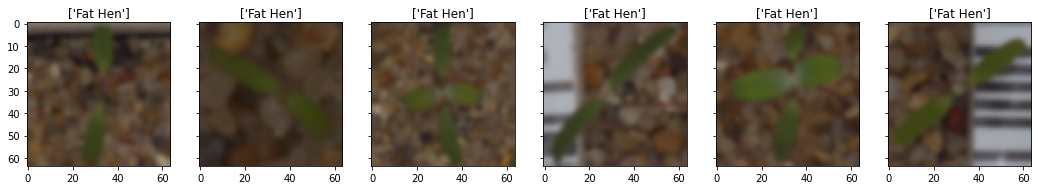

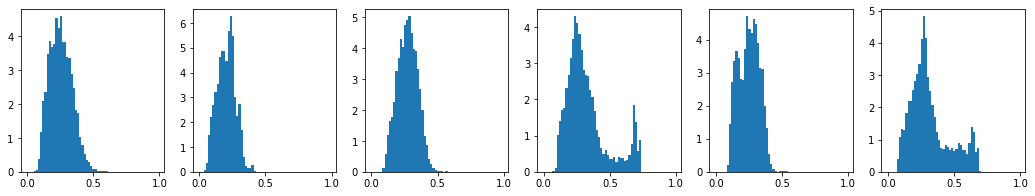

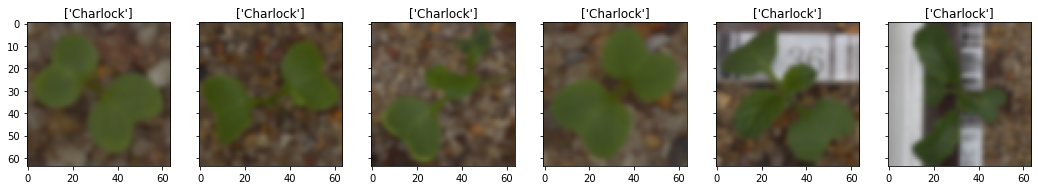

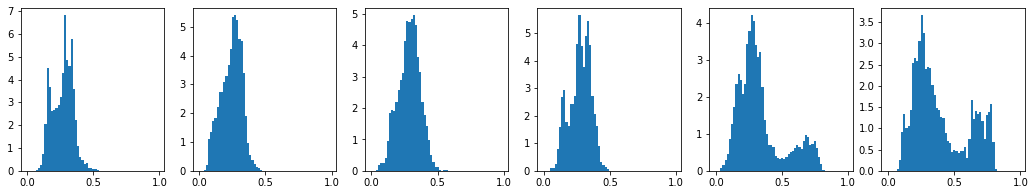

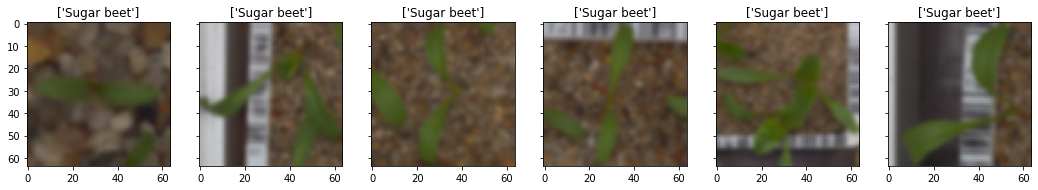

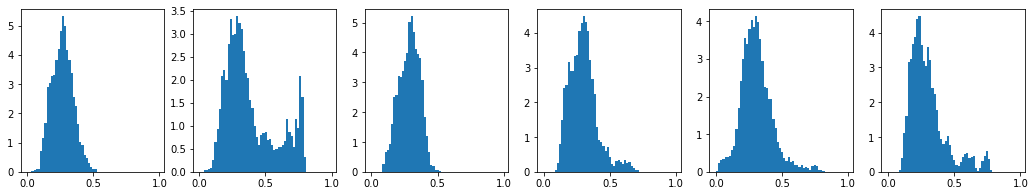

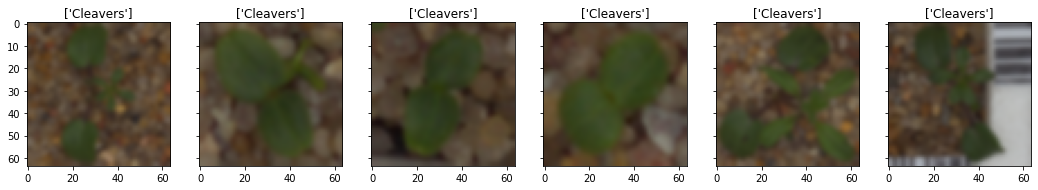

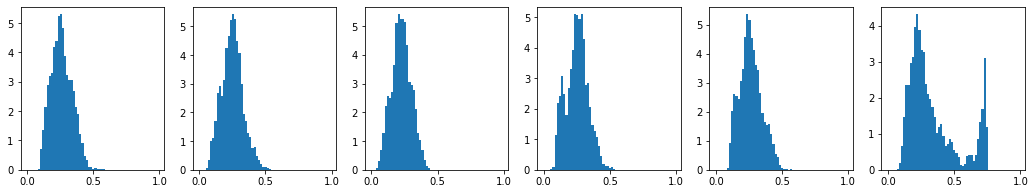

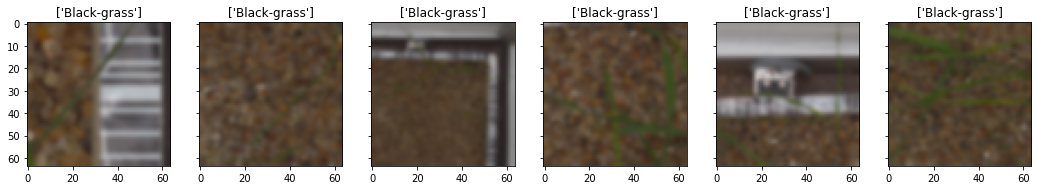

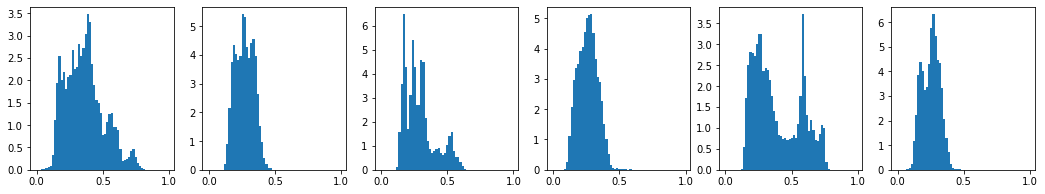

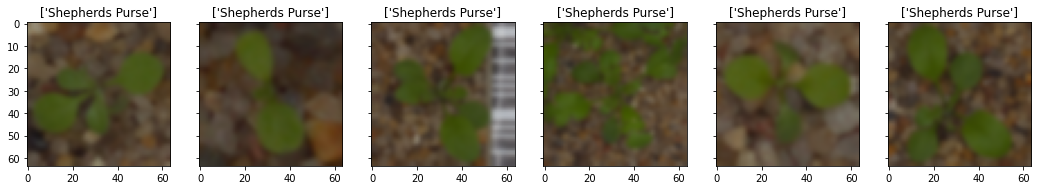

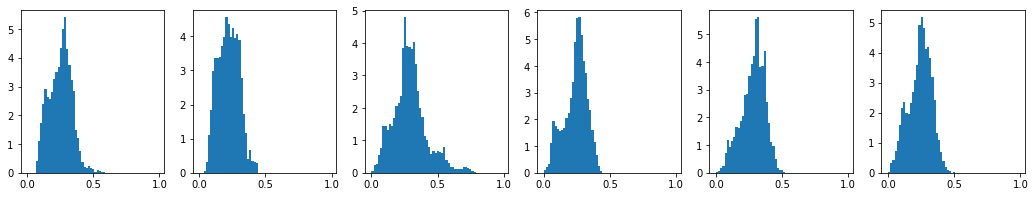

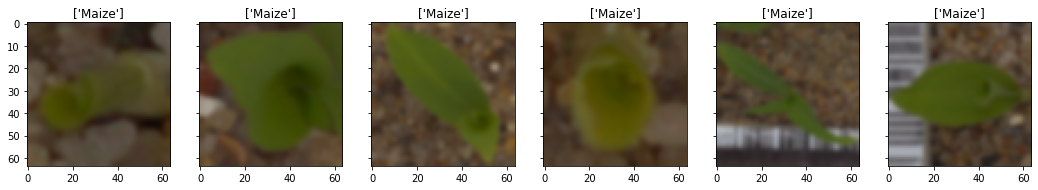

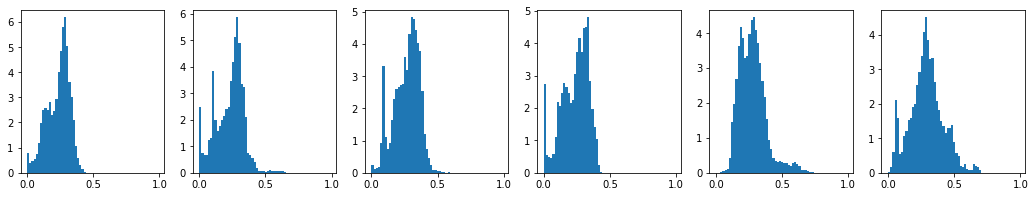

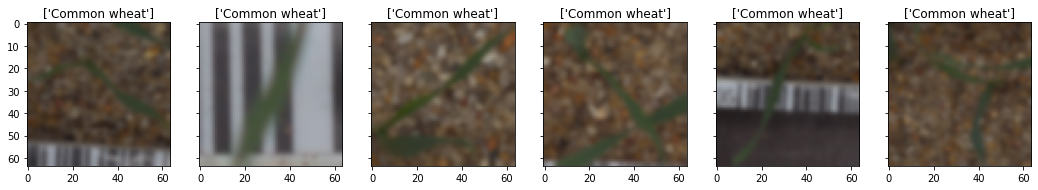

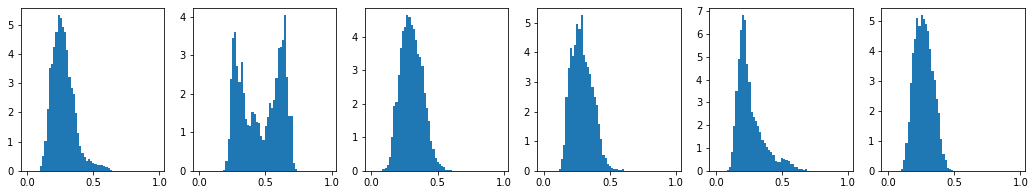

In [40]:
# show images for each category
grid_size_categ = (1,6)
for categ in labels_ordered:
    img_count = grid_size_categ[0]*grid_size_categ[1]
    categ_idx = labels_ordered.index(categ)
    categ_indexes = rnd.sample(images_by_category[categ_idx], img_count)
    plot_image_samples(grid_size_categ, images_resize_blur, labels, categ_indexes)
    plot_histograms(grid_size_categ, images_resize_blur, labels, categ_indexes)

#### One-hot encode labels

In [41]:
from sklearn.preprocessing import OneHotEncoder

# get labels encoded
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(labels)

In [42]:
# list encoded categories
encoder.categories_

[array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
        'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
        'Scentless Mayweed', 'Shepherds Purse',
        'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)]

Print label for the first image (index = 0)

In [43]:
image_index = 0 
print('First image label:', labels_df['Label'][image_index])
print('Label encoded:', y[image_index])
print('Label inverse encode:', encoder.inverse_transform([y[0]])[0][image_index])

First image label: Small-flowered Cranesbill
Label encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Label inverse encode: Small-flowered Cranesbill


#### Split the data into train, validation and test sets.

In [44]:
# split into train and val+test
X_train,  X_temp, y_train, y_temp = train_test_split(images_resize_blur, y, test_size=0.3, stratify=labels)

# split val+test into validation and test
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

In [45]:
# check shapes are as expected
print('Train shapes:', X_train.shape, y_train.shape)
print('Validation shapes:', X_val.shape, y_val.shape)
print('Test shapes:', X_test.shape, y_test.shape)

Train shapes: (3325, 64, 64, 3) (3325, 12)
Validation shapes: (713, 64, 64, 3) (713, 12)
Test shapes: (712, 64, 64, 3) (712, 12)


In [46]:
# check class frequencies across data sets
print('Original dataset class frequencies:  ', np.round(np.sum(y, axis=0)/np.sum(y), 3) * 100)
print('Train dataset class frequencies:     ', np.round(np.sum(y_train, axis=0)/np.sum(y_train), 3) * 100)
print('Validation dataset class frequencies:', np.round(np.sum(y_val, axis=0)/np.sum(y_val), 3) * 100)
print('Test dataset class frequencies:      ', np.round(np.sum(y_test, axis=0)/np.sum(y_test), 3) * 100)

Original dataset class frequencies:   [ 5.5  8.2  6.  12.9  4.7 10.  13.8  4.7 10.9  4.9 10.4  8.1]
Train dataset class frequencies:      [ 5.5  8.2  6.  12.9  4.7 10.  13.8  4.7 10.9  4.9 10.4  8.1]
Validation dataset class frequencies: [ 5.5  8.1  6.  12.9  4.6 10.1 13.7  4.6 10.9  4.8 10.5  8.1]
Test dataset class frequencies:       [ 5.6  8.3  6.  12.8  4.6 10.  13.8  4.6 10.8  4.9 10.4  8.1]


In [47]:
# compute class weights as the inverse of their frequency in the dataset
test_class_weights = 1 / (np.sum(y_train, axis=0)/np.sum(y_train) * 100)

weights = dict()
for idx, weight in enumerate(test_class_weights):
  weights[idx] = weight

print(weights)

{0: 0.18070652173913043, 1: 0.12179487179487178, 2: 0.1654228855721393, 3: 0.07768691588785048, 4: 0.21451612903225806, 5: 0.10015060240963855, 6: 0.07259825327510917, 7: 0.21451612903225806, 8: 0.09210526315789473, 9: 0.2052469135802469, 10: 0.09582132564841499, 11: 0.12360594795539034}


#### Reshape
The data can be used as is for modeling in keras so there is no need to reshape.

### Build CNN model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Accuracy, CategoricalAccuracy

We will use the 'Adam' optimizer and 'categorical_crossentropy' as loss function by default.

In [49]:
# function to create model based on parameter 'layers'
def create_model(layers, opt=Adam(), lossf=categorical_crossentropy, metrics=[CategoricalAccuracy()]):
    # neural network
    model = Sequential()

    for layer in layers:
        model.add(layer)

    # compile the model
    model.compile(optimizer=opt, 
                  loss=lossf, 
                  metrics=metrics
                 )
    return model

#### Define Layers

In [50]:
# define layers and create a model
input_shape = X_train.shape[1:]
print(input_shape)
layers = [
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),    
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(units=500, activation='relu'),
    Dense(units=12, activation='softmax')
]

model = create_model(layers)

model.summary()

(64, 64, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 500)               50176500  
_________________________________________________________________
dense_1 (Dense)              (None, 12)     

In [51]:
# model.fit(X_train, y_train, epochs=3, batch_size=100, validation_data=(X_val, y_val))
history = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/20
34/34 [==============================] - 3s 38ms/step - loss: 2.3439 - categorical_accuracy: 0.2129 - val_loss: 1.8064 - val_categorical_accuracy: 0.3548
Epoch 2/20
34/34 [==============================] - 1s 29ms/step - loss: 1.5721 - categorical_accuracy: 0.4448 - val_loss: 1.4418 - val_categorical_accuracy: 0.4867
Epoch 3/20
34/34 [==============================] - 1s 29ms/step - loss: 1.2641 - categorical_accuracy: 0.5504 - val_loss: 1.2287 - val_categorical_accuracy: 0.5666
Epoch 4/20
34/34 [==============================] - 1s 29ms/step - loss: 1.0412 - categorical_accuracy: 0.6400 - val_loss: 1.0436 - val_categorical_accuracy: 0.6508
Epoch 5/20
34/34 [==============================] - 1s 29ms/step - loss: 0.8818 - categorical_accuracy: 0.7035 - val_loss: 1.0557 - val_categorical_accuracy: 0.6227
Epoch 6/20
34/34 [==============================] - 1s 29ms/step - loss: 0.7665 - categorical_accuracy: 0.7377 - val_loss: 0.9614 - val_categorical_accuracy: 0.6942
Epoch 7/20

In [52]:
# create function to plot the loss against epochs
def plot_loss_by_epoch(history):
    # put history in a dataframe
    hist  = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Plotting loss at different epochs
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.legend(("train" , "valid") , loc =0)
    plt.show()

#### Model Evaluation

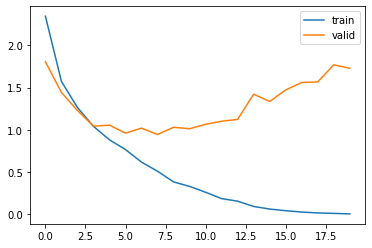

In [53]:
# plot the loss
plot_loss_by_epoch(history)

In [54]:
# evaluate the model
acc_model = model.evaluate(X_val, y_val)
acc_model

23/23 [==============================] - 0s 6ms/step - loss: 1.7286 - categorical_accuracy: 0.7237


[1.7285555601119995, 0.7237026691436768]

In [55]:
# create a dataframe to hold the scores so we can track performance across models
scores_columns = ['Model', 'Accuracy Validation']
scores = pd.DataFrame([['conv32|64|pool|conv128|dense500', acc_model[1]]],
                      columns=scores_columns)
scores

Model  Accuracy Validation
0  conv32|64|pool|conv128|dense500             0.723703

Accuracy for validation set is low.

The model is overfit as shown by the rise in validation loss after the initial drop.  
Using a higher epoch number will not help.

In [56]:
# define function to plot confusion matrix
def plot_confusion_matrix(clssf, X, y_actual, threshold=0.5):
  # get predictions from classifier and decode
  val_predict = (clssf.predict(X) > threshold ) * 1

  # decode labels
  val_labels = encoder.inverse_transform(y_actual)
  pred_labels = encoder.inverse_transform(val_predict)

  # get confusion matrix
  cm = confusion_matrix(val_labels, pred_labels)

  # get normalized confusion matrix
  cm_norm = confusion_matrix(val_labels, pred_labels, normalize='true')

  # plot confusion matrix
  plt.figure(figsize=(14,12))
  
  # add normalized rates and predictions counts
  annotations = np.array([f'{norm}\n({count})' for count, norm in zip(cm.flatten(), np.round(cm_norm,2).flatten())]).reshape((12,12))

  # plot
  ax = sns.heatmap(cm_norm, square=True, annot=annotations, fmt='', xticklabels=encoder.categories_[0],yticklabels=encoder.categories_[0], cbar=False, cmap='coolwarm')
  plt.xticks(rotation=45)

  plt.show()

  print(classification_report(val_labels, pred_labels))

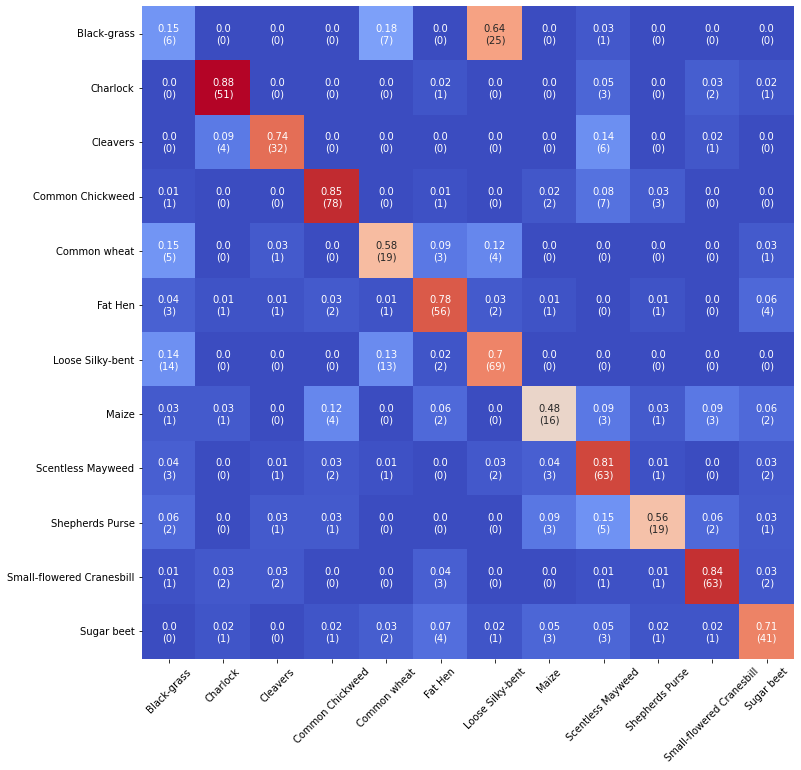

                           precision    recall  f1-score   support

              Black-grass       0.17      0.15      0.16        39
                 Charlock       0.85      0.88      0.86        58
                 Cleavers       0.84      0.74      0.79        43
         Common Chickweed       0.89      0.85      0.87        92
             Common wheat       0.44      0.58      0.50        33
                  Fat Hen       0.78      0.78      0.78        72
         Loose Silky-bent       0.67      0.70      0.69        98
                    Maize       0.57      0.48      0.52        33
        Scentless Mayweed       0.68      0.81      0.74        78
          Shepherds Purse       0.70      0.56      0.62        34
Small-flowered Cranesbill       0.88      0.84      0.86        75
               Sugar beet       0.76      0.71      0.73        58

                 accuracy                           0.72       713
                macro avg       0.69      0.67      0.68    

In [57]:
# plot confusion matrix for validation set
plot_confusion_matrix(model, X_val, y_val)

#### Validation Set Confusion Matrix - Observations

* `Black-grass` is misclassified as `Loose Silky-bent` at a higher rate than the correct classification
*  `Loose Silky-bent` is often misclassified as `Black-grass`
* `Common wheat` is often misclassified as `Black-grass`
* `Charlock` and `Small-flowered Cranesbill` have the highest rate of true positives

### Model Predictions - Test set
(This is listed as part of the assigment in the pdf version of the project)


In [58]:
print('Test dataset shape', X_test.shape)

Test dataset shape (712, 64, 64, 3)




Actual label: ['Scentless Mayweed']
Predicted label: ['Scentless Mayweed']


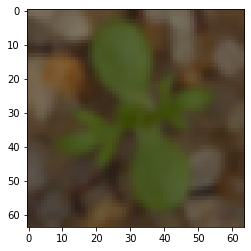



Actual label: ['Black-grass']
Predicted label: ['Loose Silky-bent']


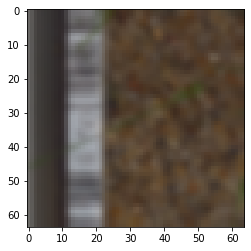



Actual label: ['Common wheat']
Predicted label: ['Loose Silky-bent']


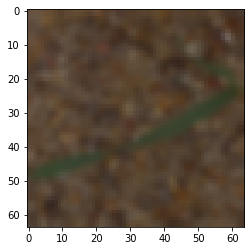



Actual label: ['Common wheat']
Predicted label: ['Common wheat']


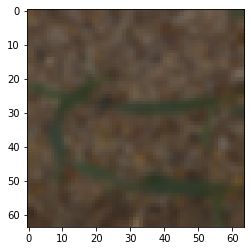



Actual label: ['Sugar beet']
Predicted label: ['Fat Hen']


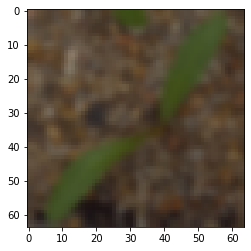

In [59]:
# list of indexes as per assignment pdf instructions
prediction_indexes = [2, 3, 33, 36, 59]

predictions = (model.predict(X_test[prediction_indexes]) > 0.5) * 1

predicted_labels = encoder.inverse_transform(predictions)
actual_labels = encoder.inverse_transform(y_test[prediction_indexes])

# plot images
for img, pred, actual in zip(X_test[prediction_indexes], predicted_labels, actual_labels):
  print('\n================================\n')
  print('Actual label:', actual)
  print('Predicted label:', pred)
  plt.imshow(img)
  plt.show()

### Model improvements

#### Padding
We'll set padding to 'same' to see if keeping a larger image in the pipeline will improve performance and raise the number of epochs.

#### Model 2

In [60]:
input_shape = X_train.shape[1:]
print(input_shape)

# same layers but with padding = 'same'
layers = [
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),    
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(units=500, activation='relu'),
    Dense(units=12, activation='softmax')
]

model2 = create_model(layers)

model2.summary()

(64, 64, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               57600500  
_________________________________________________________________
dense_3 (Dense)              (None, 12)   

In [61]:
# fit the model
history2 = model2.fit(X_train, y_train, epochs=40, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/40
34/34 [==============================] - 2s 40ms/step - loss: 3.4456 - categorical_accuracy: 0.2397 - val_loss: 2.4204 - val_categorical_accuracy: 0.2118
Epoch 2/40
34/34 [==============================] - 1s 31ms/step - loss: 2.3542 - categorical_accuracy: 0.2036 - val_loss: 2.2785 - val_categorical_accuracy: 0.2146
Epoch 3/40
34/34 [==============================] - 1s 31ms/step - loss: 2.0351 - categorical_accuracy: 0.3023 - val_loss: 1.9107 - val_categorical_accuracy: 0.3114
Epoch 4/40
34/34 [==============================] - 1s 31ms/step - loss: 1.7745 - categorical_accuracy: 0.3859 - val_loss: 1.7254 - val_categorical_accuracy: 0.3955
Epoch 5/40
34/34 [==============================] - 1s 31ms/step - loss: 1.6337 - categorical_accuracy: 0.4292 - val_loss: 1.6700 - val_categorical_accuracy: 0.3955
Epoch 6/40
34/34 [==============================] - 1s 31ms/step - loss: 1.5818 - categorical_accuracy: 0.4532 - val_loss: 1.6017 - val_categorical_accuracy: 0.4376
Epoch 7/40

##### Model 2 evaluation

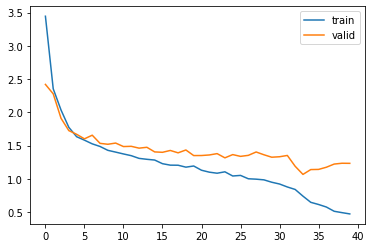

In [62]:
# plot loss
plot_loss_by_epoch(history2)

In [63]:
# evaluate the model
acc_model = model2.evaluate(X_val, y_val)
acc_model

23/23 [==============================] - 0s 6ms/step - loss: 1.2333 - categorical_accuracy: 0.6494


[1.2332631349563599, 0.6493688821792603]

In [64]:
# add scores to the dataframe
scores.loc[len(scores.index)] = ['conv32|64|pool|conv128|dense500 - padding=same', acc_model[1]]
scores

Model  Accuracy Validation
0                 conv32|64|pool|conv128|dense500             0.723703
1  conv32|64|pool|conv128|dense500 - padding=same             0.649369

The model accuracy is lower than the first model.

There might possibly be more accuracy to be had with more epochs.

Next, we will try to simplify the model and see if that improves performance.

### Model 3

In [65]:
input_shape = X_train.shape[1:]
print(input_shape)

# remove one conv layer
layers = [
    Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),    
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(units=500, activation='relu'),
    Dense(units=12, activation='softmax')
]

model3 = create_model(layers)

model3.summary()

(64, 64, 3)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 107648)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               53824500  
_________________________________________________________________
dense_5 (Dense)              (None, 12)                6012      
Total params: 53,906,160
Trainable params: 53,906,160
Non-trainable params: 0
______________________________

In [66]:
history3 = model3.fit(X_train, y_train, epochs=40, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/40
34/34 [==============================] - 2s 31ms/step - loss: 3.4316 - categorical_accuracy: 0.2107 - val_loss: 2.4384 - val_categorical_accuracy: 0.1529
Epoch 2/40
34/34 [==============================] - 1s 24ms/step - loss: 2.3213 - categorical_accuracy: 0.1943 - val_loss: 2.3078 - val_categorical_accuracy: 0.2244
Epoch 3/40
34/34 [==============================] - 1s 24ms/step - loss: 2.0627 - categorical_accuracy: 0.2881 - val_loss: 1.9268 - val_categorical_accuracy: 0.3380
Epoch 4/40
34/34 [==============================] - 1s 24ms/step - loss: 1.7895 - categorical_accuracy: 0.3768 - val_loss: 1.7949 - val_categorical_accuracy: 0.4011
Epoch 5/40
34/34 [==============================] - 1s 24ms/step - loss: 1.6789 - categorical_accuracy: 0.4066 - val_loss: 1.6694 - val_categorical_accuracy: 0.4208
Epoch 6/40
34/34 [==============================] - 1s 24ms/step - loss: 1.5811 - categorical_accuracy: 0.4490 - val_loss: 1.6476 - val_categorical_accuracy: 0.3913
Epoch 7/40

##### Model 3 evaluation

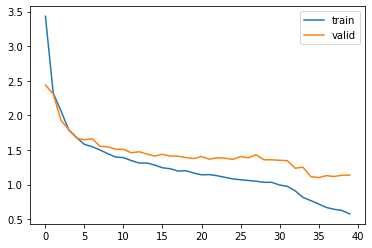

In [67]:
plot_loss_by_epoch(history3)

In [68]:
# evaluate the model
acc_model = model3.evaluate(X_val, y_val)
acc_model

23/23 [==============================] - 0s 5ms/step - loss: 1.1376 - categorical_accuracy: 0.6592


[1.1376171112060547, 0.6591865420341492]

In [69]:
scores.loc[len(scores.index)] = ['conv64|pool|conv128|dense500', acc_model[1]]
scores

Model  Accuracy Validation
0                 conv32|64|pool|conv128|dense500             0.723703
1  conv32|64|pool|conv128|dense500 - padding=same             0.649369
2                    conv64|pool|conv128|dense500             0.659187

Performance improved over previous model but is lower than the original

### Model 4

We will try raising the units in the dense layer as compared to the first model

In [70]:
# define layers and create a model
input_shape = X_train.shape[1:]
print(input_shape)

# initializer
# init = LecunNormal(seed=0)

layers = [
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(units=1000),
    Dense(units=12, activation='softmax')
]

model4 = create_model(layers)

model4.summary()

(64, 64, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              100353000 
_________________________________________________________________
dense_7 (Dense)              (None, 12)   

In [71]:
# fit the model
history4 = model4.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/20
34/34 [==============================] - 2s 41ms/step - loss: 8.1537 - categorical_accuracy: 0.2023 - val_loss: 2.4284 - val_categorical_accuracy: 0.1290
Epoch 2/20
34/34 [==============================] - 1s 36ms/step - loss: 2.4207 - categorical_accuracy: 0.1398 - val_loss: 2.4266 - val_categorical_accuracy: 0.1164
Epoch 3/20
34/34 [==============================] - 1s 36ms/step - loss: 2.4201 - categorical_accuracy: 0.1359 - val_loss: 2.4150 - val_categorical_accuracy: 0.1374
Epoch 4/20
34/34 [==============================] - 1s 36ms/step - loss: 2.4180 - categorical_accuracy: 0.1377 - val_loss: 2.4139 - val_categorical_accuracy: 0.1374
Epoch 5/20
34/34 [==============================] - 1s 36ms/step - loss: 2.4175 - categorical_accuracy: 0.1314 - val_loss: 2.4138 - val_categorical_accuracy: 0.1374
Epoch 6/20
34/34 [==============================] - 1s 36ms/step - loss: 2.4180 - categorical_accuracy: 0.1377 - val_loss: 2.4139 - val_categorical_accuracy: 0.1374
Epoch 7/20

##### Model 4 Evaluation

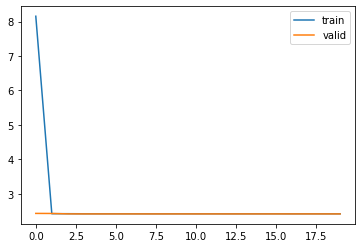

In [72]:
plot_loss_by_epoch(history4)

In [73]:
# evaluate the model
acc_model = model4.evaluate(X_val, y_val)
acc_model

23/23 [==============================] - 0s 7ms/step - loss: 2.4138 - categorical_accuracy: 0.1374


[2.4138476848602295, 0.13744740188121796]

In [74]:
scores.loc[len(scores.index)] = ['conv32|64|pool|conv128|dense1000', acc_model[1]]
scores

Model  Accuracy Validation
0                 conv32|64|pool|conv128|dense500             0.723703
1  conv32|64|pool|conv128|dense500 - padding=same             0.649369
2                    conv64|pool|conv128|dense500             0.659187
3                conv32|64|pool|conv128|dense1000             0.137447

This model got stuck.

### Model 5
We will train using class weights (computed previously when splitting the dataset). 

In [75]:
# define layers and create a model
# no difference in the layers - we'll just pass class weights to the fit() function
input_shape = X_train.shape[1:]
print(input_shape)
layers = [
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),    
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(units=500, activation='relu'),
    Dense(units=12, activation='softmax')
]

model5 = create_model(layers)

model5.summary()

(64, 64, 3)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               50176500  
_________________________________________________________________
dense_9 (Dense)              (None, 12)   

In [76]:
history5 = model5.fit(X_train, y_train, epochs=40, batch_size=100, validation_data=(X_val, y_val), class_weight=weights)

Epoch 1/40
34/34 [==============================] - 2s 34ms/step - loss: 0.4292 - categorical_accuracy: 0.0815 - val_loss: 2.4854 - val_categorical_accuracy: 0.0603
Epoch 2/40
34/34 [==============================] - 1s 29ms/step - loss: 0.2984 - categorical_accuracy: 0.0532 - val_loss: 2.4850 - val_categorical_accuracy: 0.0477
Epoch 3/40
34/34 [==============================] - 1s 29ms/step - loss: 0.2983 - categorical_accuracy: 0.0550 - val_loss: 2.4855 - val_categorical_accuracy: 0.1052
Epoch 4/40
34/34 [==============================] - 1s 29ms/step - loss: 0.2983 - categorical_accuracy: 0.0848 - val_loss: 2.4856 - val_categorical_accuracy: 0.1052
Epoch 5/40
34/34 [==============================] - 1s 29ms/step - loss: 0.2982 - categorical_accuracy: 0.0950 - val_loss: 2.4855 - val_categorical_accuracy: 0.1052
Epoch 6/40
34/34 [==============================] - 1s 29ms/step - loss: 0.2982 - categorical_accuracy: 0.0749 - val_loss: 2.4848 - val_categorical_accuracy: 0.1094
Epoch 7/40

#### Model 5 Evaluation

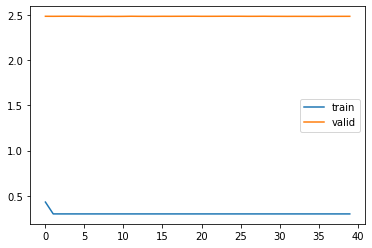

In [77]:
# plot loss
plot_loss_by_epoch(history5)

In [78]:
# evaluate the model
acc_model = model5.evaluate(X_val, y_val)
acc_model

23/23 [==============================] - 0s 4ms/step - loss: 2.4850 - categorical_accuracy: 0.1094


[2.485004425048828, 0.10939691215753555]

In [79]:
scores.loc[len(scores.index)] = ['conv32|64|pool|conv128|dense1000 - w/class weights', acc_model[1]]
scores

Model  Accuracy Validation
0                    conv32|64|pool|conv128|dense500             0.723703
1     conv32|64|pool|conv128|dense500 - padding=same             0.649369
2                       conv64|pool|conv128|dense500             0.659187
3                   conv32|64|pool|conv128|dense1000             0.137447
4  conv32|64|pool|conv128|dense1000 - w/class wei...             0.109397

This model got stuck

### Test Set Confusion Matrix and Performance

In [80]:
# use best model to evaluate against test data 
model.evaluate(X_test, y_test)

23/23 [==============================] - 0s 6ms/step - loss: 1.5804 - categorical_accuracy: 0.7444


[1.5804247856140137, 0.7443820238113403]

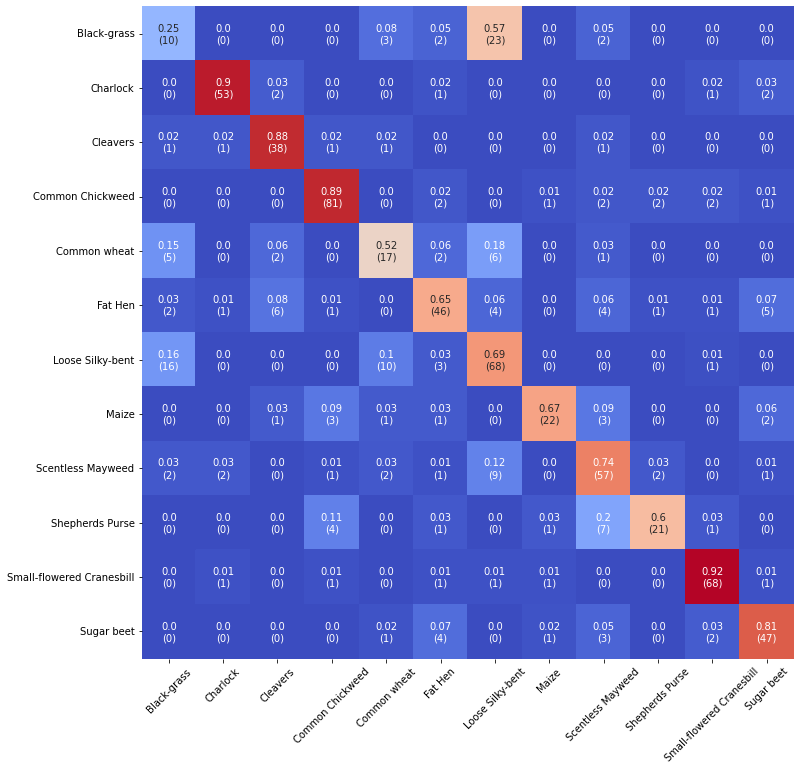

                           precision    recall  f1-score   support

              Black-grass       0.28      0.25      0.26        40
                 Charlock       0.91      0.90      0.91        59
                 Cleavers       0.78      0.88      0.83        43
         Common Chickweed       0.88      0.89      0.89        91
             Common wheat       0.49      0.52      0.50        33
                  Fat Hen       0.72      0.65      0.68        71
         Loose Silky-bent       0.61      0.69      0.65        98
                    Maize       0.85      0.67      0.75        33
        Scentless Mayweed       0.71      0.74      0.73        77
          Shepherds Purse       0.81      0.60      0.69        35
Small-flowered Cranesbill       0.89      0.92      0.91        74
               Sugar beet       0.80      0.81      0.80        58

                 accuracy                           0.74       712
                macro avg       0.73      0.71      0.72    

In [81]:
# TODO change model to correct model name
plot_confusion_matrix(model, X_test, y_test)

Performance against the test data with the initial model is close to the accuracy against the validation set with the same model.

The model generalizes well.

The confusion matrix is similar to that of validation set predictions in that similar classification errors are made.  
E.g. `Black-grass` is often predicted to be `Loose Silky-bent`

## Conclusions and Takeaways
* Tuning CNN's is not easy!!
* Changing runtime between CPU, GPU and TPU in Google colab changed the results of the training
* Often a model would get 'stuck' during training (no change in loss after each epoch), but other times it would work as expected (loss drop)
* Many combination were tried but it's hard to get consistent results across runs
* Different kernel initializers didn't seem to make a difference

### Possible improvements
* Add dropout layers
* Add batch normalization layers
* Undersample or oversample data
* Use data generator to transform images
* Use the original larger dataset from Kaggle